## Homework 5 DSC 441

### Name: Jonathan Sands

### Date:11/19/2020

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import scipy.stats as stats
from kneed import KneeLocator
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn import tree
from sklearn.metrics import mean_squared_log_error, confusion_matrix

This first kernel will be me uploading the data and formating it for pre screening.

Grab information on the data, find missing values, means, stds, etc

In [31]:
#Retrieve data
data = pd.read_csv(r'D:\DePaul\DSC 441\seeds_dataset.txt', sep = '\t', names = ['Area', 'Perimeter', 'Compactness','Length of Kernel', 'Width of Kernel', 'Asymmetry Coefficient', 'Length of Kernel Groove', 'Class'])

print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     210 non-null    float64
 1   Perimeter                210 non-null    float64
 2   Compactness              210 non-null    float64
 3   Length of Kernel         210 non-null    float64
 4   Width of Kernel          210 non-null    float64
 5   Asymmetry Coefficient    210 non-null    float64
 6   Length of Kernel Groove  210 non-null    float64
 7   Class                    210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB
None


,Area,Perimeter,Compactness,Length of Kernel,Width of Kernel,Asymmetry Coefficient,Length of Kernel Groove,Class
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


We can see that several tuples have missing values, this is something we should fix. 

In [32]:
#Seperate the Features from the target 
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X = pd.DataFrame(X, columns = ['Area', 'Perimeter', 'Compactness','Length of Kernel', 'Width of Kernel', 'Asymmetry Coefficient', 'Length of Kernel Groove'])
y = pd.DataFrame(data.iloc[:,-1], columns = ['Class'])

#Normalize the features for future use
X_Normalized = pd.DataFrame(stats.zscore(X), columns = ['Area', 'Perimeter', 'Compactness','Length of Kernel', 'Width of Kernel', 'Asymmetry Coefficient', 'Length of Kernel Groove'])
X_Normalized

,Area,Perimeter,Compactness,Length of Kernel,Width of Kernel,Asymmetry Coefficient,Length of Kernel Groove
0,0.142098,0.215462,0.000061,0.304218,0.141702,-0.986152,-0.383577
1,0.011188,0.008224,0.428515,-0.168625,0.197432,-1.788166,-0.922013
2,-0.192067,-0.360201,1.442383,-0.763637,0.208048,-0.667479,-1.189192
3,-0.347091,-0.475333,1.039381,-0.688978,0.319508,-0.960818,-1.229983
4,0.445257,0.330595,1.374509,0.066666,0.805159,-1.563495,-0.475356
...,...,...,...,...,...,...,...
205,-0.915515,-1.043321,0.309736,-1.112048,-0.736716,-0.046135,-1.097413
206,-1.246235,-1.288937,-0.844122,-1.105261,-1.230328,0.416540,-0.826156
207,-0.567571,-0.690247,0.733948,-0.888070,-0.070604,3.076588,-0.718060
208,-1.036090,-1.035645,-0.801701,-1.026077,-1.121521,-0.068135,-0.742535


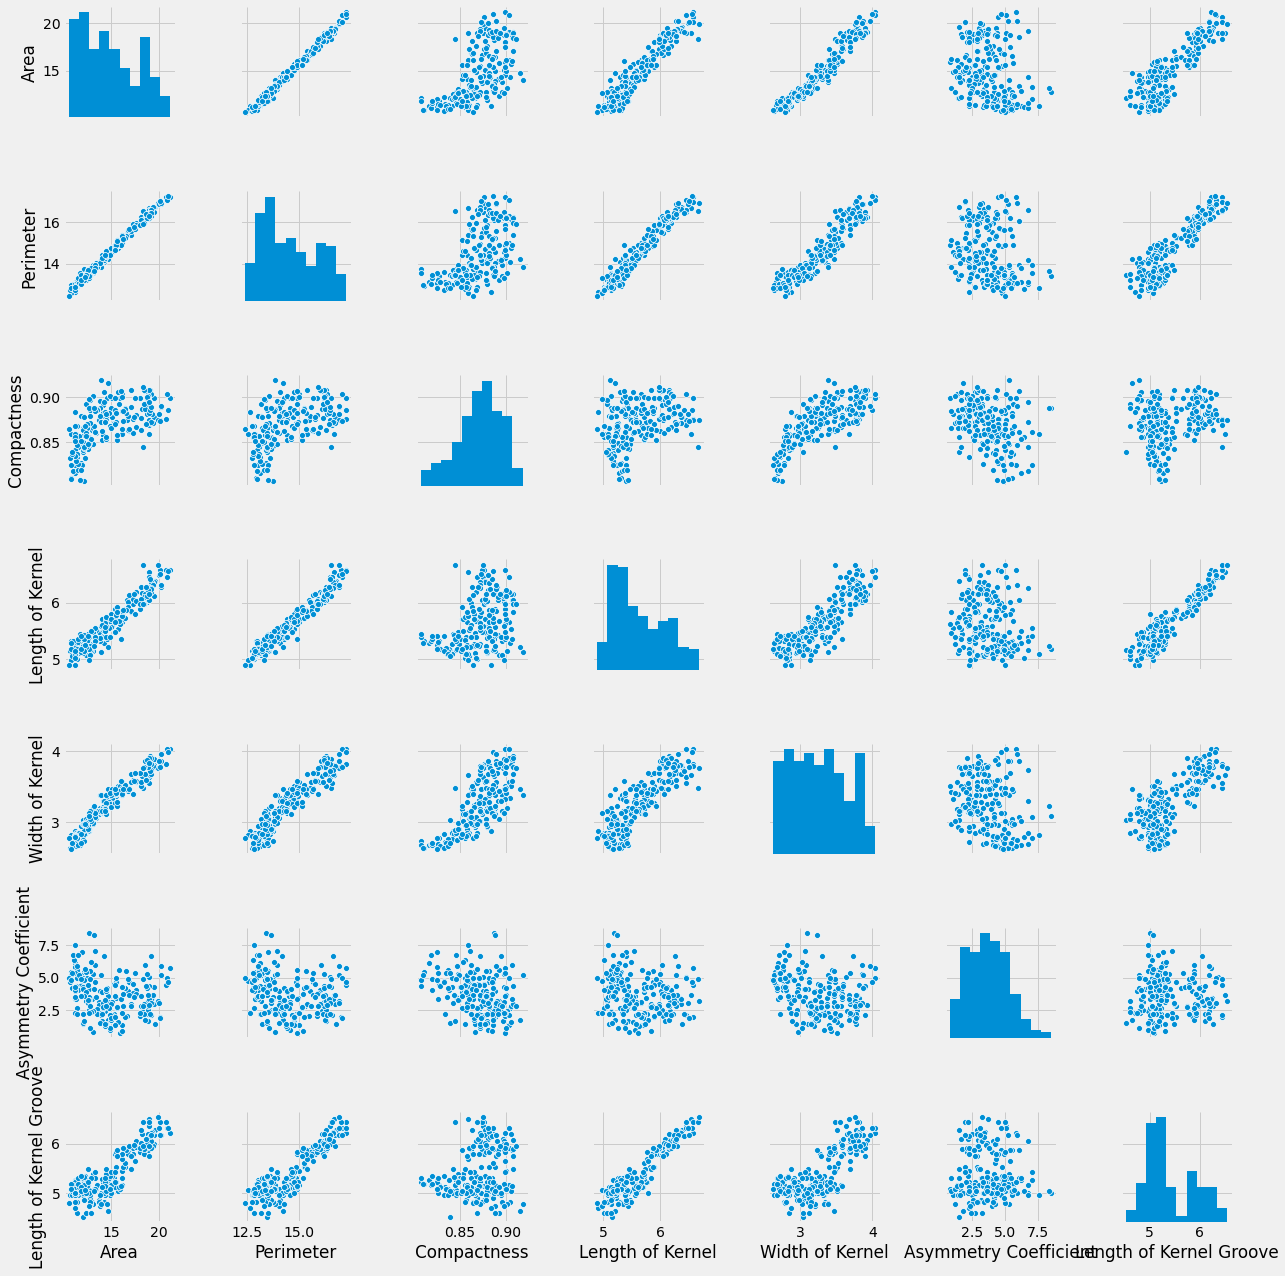

In [33]:
#View attribute correlation and distributions
sns.pairplot(X)

Above we can see that length of kernel, width of kernel and Area are highly correlated. Area and Perimeter are highly correlated. Compactness seems relatively independent, as does Asymmetry Coefficient. PCA may help solve this problem.

In [59]:
#Apply PCA for future use
pca = PCA(n_components = 3)
princ_components = pca.fit_transform(X_Normalized)
princDF = pd.DataFrame(data = princ_components, columns = ['comp 1', 'comp 2', 'comp 3'])

Next, I will run a KMeans test using 3 clusters.

### Problem 1 Question a. How are cluster centers calculated?

The KMeans algorithm starts with k randomly placed centroids. Once random cluster centers are assigned, each point is assigned to the centroid to which it is closest to. The group of points assigned to this centroid forms the cluster. We recompute the mean point and set this as a new centroid, we repeat this step until a convergence criterion is satisfied.

### Problem 1 Question b.  What similarity measure was used?

The default similarity measure for KMeans is Euclidean distance. 

### Problem 1 Question c. For each k, report the following:

### i. Final cluster centers
### ii. Number of elements in each cluster
### iii. The class distribution within each cluster
### iv. In your opinion, which k should be selected? Explain your selection.
### v. For the selected k in iv, analyze and report if the normalization of the attributes will influence the clustering results.

(I used 9 different clusters in order to have a better visualization of the elbow later)

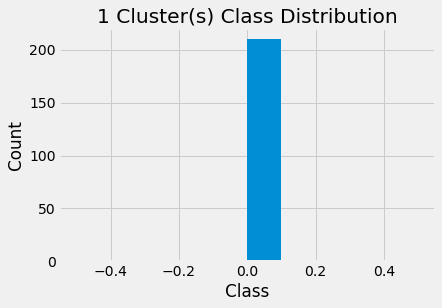

The cluster centroids are at 

[[14.84752381 14.55928571  0.87099857  5.62853333  3.25860476  3.70020095
   5.40807143]]


The value counts for the clusters displayed above are

0    210
Name: km, dtype: int64


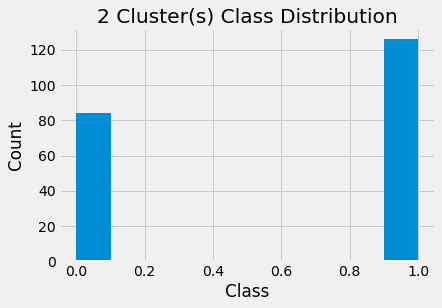

The cluster centroids are at 

[[17.94238095 15.95333333  0.88420952  6.08641667  3.6414881   3.42284643
   5.90419048]
 [12.78428571 13.62992063  0.86219127  5.32327778  3.00334921  3.88510397
   5.0773254 ]]


The value counts for the clusters displayed above are

1    126
0     84
Name: km, dtype: int64


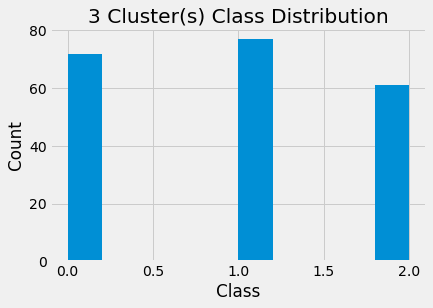

The cluster centroids are at 

[[14.64847222 14.46041667  0.87916667  5.56377778  3.27790278  2.64893333
   5.19231944]
 [11.96441558 13.27480519  0.8522      5.22928571  2.87292208  4.75974026
   5.08851948]
 [18.72180328 16.29737705  0.88508689  6.20893443  3.72267213  3.60359016
   6.06609836]]


The value counts for the clusters displayed above are

1    77
0    72
2    61
Name: km, dtype: int64


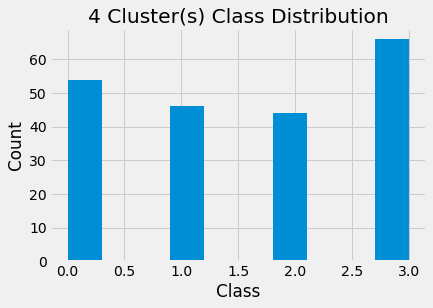

The cluster centroids are at 

[[18.96296296 16.39666667  0.88595185  6.24272222  3.74992593  3.54033333
   6.10077778]
 [13.39108696 13.86521739  0.87424565  5.366       3.11428261  2.41580652
   4.99067391]
 [15.71909091 14.97659091  0.88038636  5.74518182  3.3985      3.18704773
   5.44838636]
 [11.91439394 13.26151515  0.85024242  5.23122727  2.86393939  5.06828788
   5.10534848]]


The value counts for the clusters displayed above are

3    66
0    54
1    46
2    44
Name: km, dtype: int64


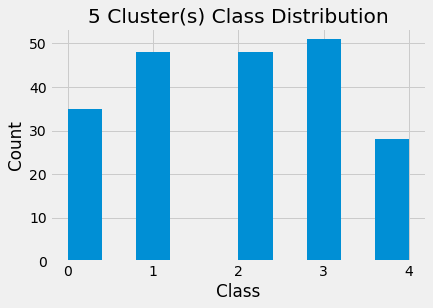

The cluster centroids are at 

[[12.18828571 13.33085714  0.86128571  5.21045714  2.92937143  3.08614286
   4.97625714]
 [19.15104167 16.46916667  0.88708958  6.26885417  3.7729375   3.46041667
   6.12725   ]
 [14.625625   14.444375    0.88059792  5.56377083  3.27639583  2.37129583
   5.14375   ]
 [11.93627451 13.28196078  0.84902353  5.24192157  2.86372549  5.43896078
   5.12133333]
 [16.47714286 15.34428571  0.879125    5.86864286  3.47717857  3.98992857
   5.69035714]]


The value counts for the clusters displayed above are

3    51
2    48
1    48
0    35
4    28
Name: km, dtype: int64


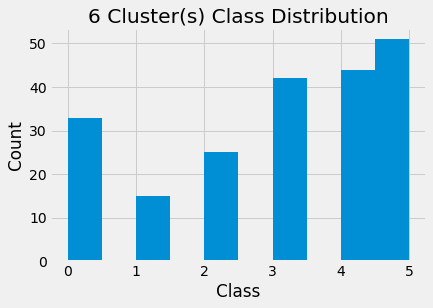

The cluster centroids are at 

[[18.95454545 16.38878788  0.8868      6.24748485  3.74469697  2.72354545
   6.11945455]
 [19.58333333 16.646       0.88772667  6.31586667  3.83506667  5.08153333
   6.1444    ]
 [16.562      15.3916      0.878244    5.88816     3.4808      4.10948
   5.7252    ]
 [11.9847619  13.29357143  0.85079524  5.24138095  2.8797381   5.6732619
   5.12197619]
 [12.09045455 13.30977273  0.85708636  5.21740909  2.90065909  3.34375
   5.00531818]
 [14.69294118 14.47411765  0.88094314  5.57213725  3.28643137  2.40790588
   5.15882353]]


The value counts for the clusters displayed above are

5    51
4    44
3    42
0    33
2    25
1    15
Name: km, dtype: int64


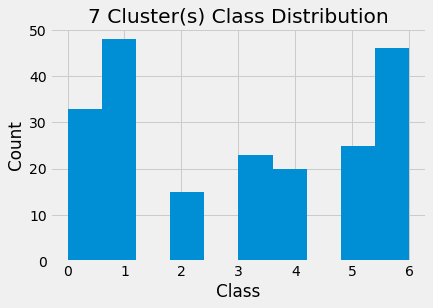

The cluster centroids are at 

[[18.95454545 16.38878788  0.8868      6.24748485  3.74469697  2.72354545
   6.11945455]
 [14.77375    14.51375     0.88103333  5.583875    3.2983125   2.43983542
   5.16020833]
 [19.58333333 16.646       0.88772667  6.31586667  3.83506667  5.08153333
   6.1444    ]
 [12.57347826 13.48782609  0.86816087  5.24330435  2.99334783  2.46026522
   4.94843478]
 [12.3655     13.437       0.859035    5.2724      2.9606      6.3741
   5.1237    ]
 [16.562      15.3916      0.878244    5.88816     3.4808      4.10948
   5.7252    ]
 [11.71826087 13.18521739  0.84641957  5.21332609  2.82191304  4.50054348
   5.09736957]]


The value counts for the clusters displayed above are

1    48
6    46
0    33
5    25
3    23
4    20
2    15
Name: km, dtype: int64


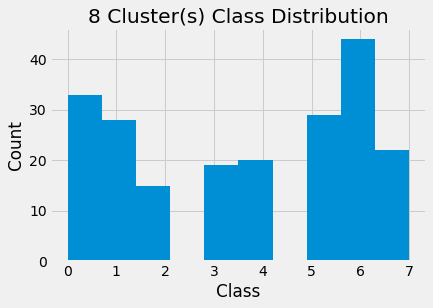

The cluster centroids are at 

[[18.95454545 16.38878788  0.8868      6.24748485  3.74469697  2.72354545
   6.11945455]
 [14.00607143 14.1575      0.87820714  5.47685714  3.20039286  3.06775
   5.05110714]
 [19.58333333 16.646       0.88772667  6.31586667  3.83506667  5.08153333
   6.1444    ]
 [12.40421053 13.40736842  0.86688947  5.20978947  2.97063158  2.36032105
   4.92305263]
 [12.3655     13.437       0.859035    5.2724      2.9606      6.3741
   5.1237    ]
 [15.37551724 14.79206897  0.88289655  5.66348276  3.37317241  2.06831379
   5.28489655]
 [11.64659091 13.15681818  0.84505455  5.20677273  2.80931818  4.5045
   5.09772727]
 [16.60136364 15.41681818  0.87734545  5.90736364  3.47768182  4.29718182
   5.75372727]]


The value counts for the clusters displayed above are

6    44
0    33
5    29
1    28
7    22
4    20
3    19
2    15
Name: km, dtype: int64


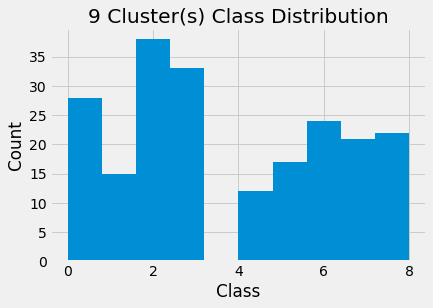

The cluster centroids are at 

[[14.32214286 14.29857143  0.8803      5.51582143  3.25142857  3.06035714
   5.08653571]
 [19.58333333 16.646       0.88772667  6.31586667  3.83506667  5.08153333
   6.1444    ]
 [12.05078947 13.33710526  0.8508      5.25155263  2.87002632  4.12368421
   5.09031579]
 [18.95454545 16.38878788  0.8868      6.24748485  3.74469697  2.72354545
   6.11945455]
 [13.0225     13.70666667  0.87055     5.32691667  3.08033333  6.39941667
   5.136     ]
 [12.50411765 13.43        0.8706      5.20170588  3.00052941  2.07859412
   4.90917647]
 [16.55916667 15.38875     0.87839167  5.88129167  3.48145833  4.19570833
   5.718875  ]
 [11.21809524 12.9547619   0.83992381  5.16466667  2.75080952  5.60504762
   5.09204762]
 [15.36090909 14.79954545  0.88109091  5.68745455  3.355       1.72818636
   5.29354545]]


The value counts for the clusters displayed above are

2    38
3    33
0    28
6    24
8    22
7    21
5    17
1    15
4    12
Name: km, dtype: int64


In [60]:
#Create a clustering algorithm for 3, 4, 5, and 6 clusters and store their SSE score in an array
#This SSE score will be used for the elbow test

SSE = []
Centroids = []

for i in range(1,10):
    
    km = KMeans(n_clusters = i, n_init = 20, init = 'random', random_state = 1).fit(X)
    
    SSE.append(km.inertia_)
    
    Centroids.append(km.cluster_centers_)
    
    x = km.labels_
    
    plt.figure()
    plt.hist(x)
    plt.title('{} Cluster(s) Class Distribution'. format(i))
    plt.xlabel('Class')
    plt.ylabel('Count')  
    plt.show()
    
    print('The cluster centroids are at \n\n{}'.format(km.cluster_centers_))
    
    kmean = pd.DataFrame(km.labels_, columns = ['km'])
    
    print('\n\nThe value counts for the clusters displayed above are\n')
    print(kmean['km'].value_counts())

Just based on the above information, I would select 3 clusters because we know the data is evenly distributed over the 3 classes and 3 clusters comes the closest to an even distribution. Below I will apply the elbow test to confirm this. The elbow test checks the decrease in inertia, and we look for "elbow" point that appears after the faster rates of decrease and just before the steady, slower rate of decrease.

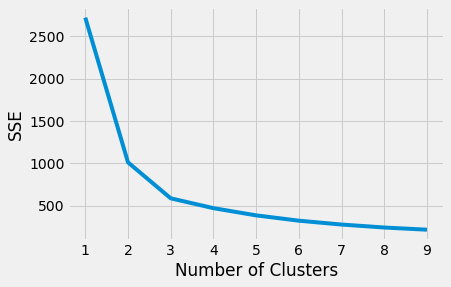

In [61]:
plt.style.use("fivethirtyeight")
plt.plot(range(1,10), SSE)
plt.xticks(range(1,10))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

While I'm pretty sure the elbow is located at 3, we should double check it with a function known as KneeLocator.

In [62]:
#Elbow test confirmation
kl = KneeLocator(range(1,10), SSE, curve = 'convex', direction = 'decreasing')

print('The elbow test tells us the ideal cluster size is : {}'.format(kl.elbow))

print('\nThis elbow test is based on the decrease in interia, with 3 clusters having an interia of : \n{}'.format(SSE[2]))

#Misclassification Error of the test for 3 clusters
km = KMeans(n_clusters = 3, n_init = 20, init = 'random', random_state = 1).fit(X)

k_means_predicted = pd.DataFrame(km.predict(X) + 1, columns = ['Class'])

accuracy = round((np.mean(k_means_predicted==y))*100)

print('\nHowever, our test accuracy is very low at: \n{}'.format(accuracy))

The elbow test tells us the ideal cluster size is : 3

This elbow test is based on the decrease in interia, with 3 clusters having an interia of : 
587.3186115940429

However, our test accuracy is very low at: 
Class    29.0
dtype: float64


Computing for the elbow test, we can confirm that the best option is 3. 

In [63]:
#Normalized Kmeans
km = KMeans(n_clusters = 3, n_init = 20, init = 'random', random_state = 1).fit(princDF)

SSE = km.inertia_

print('The decrease in intertia for the normalized set is : {}'.format(SSE))

#Misclassification error
k_means_predicted = pd.DataFrame(km.predict(princDF) + 1, columns = ['Class'])

accuracy = round((np.mean(k_means_predicted==y))*100)

print('Our new, normalized accuracy is: {} percent'.format(accuracy))

print('Normalized centroids are at: {}'.format(km.cluster_centers_))

The decrease in intertia for the normalized set is : 412.6540713494185
Our new, normalized accuracy is: Class    35.0
dtype: float64 percent
Normalized centroids are at: [[-2.34014325 -0.63805298 -0.01595385]
 [ 2.80525792 -0.41690012 -0.00734257]
 [-0.30280708  1.01713985  0.02256494]]


Normalizing the attributes clearly helped. for this I used z-score normalization initially but after noticing that many of the attributes were highly correlated, I decided to use PCA as a dimensionality reduction tool. 

This gave me the data frame princDF (short for pinciple component Data Frame). I decided to take 3 principle components because area, perimeter, length, and width attributes were all strongly, positively correlated and I assumed that PCA would notice this and be able to combine them easily.


Based on the information I obtained, I would suggest using 3 clusters, normalized. It proved to be the elbow point in the WSS test and also had the most even distribution, which resembles our data, which has 70 points in each class.

I began my tests by scaling the data which standardizes the data to the mean, giving it a mean and unit variance of zero.

## Hierarchical Clustering

### Apply single linkage algorithm and report
### 1. The dendrogram
### 2. The class distribution at the level of the dendrogram where there are only three clusters.

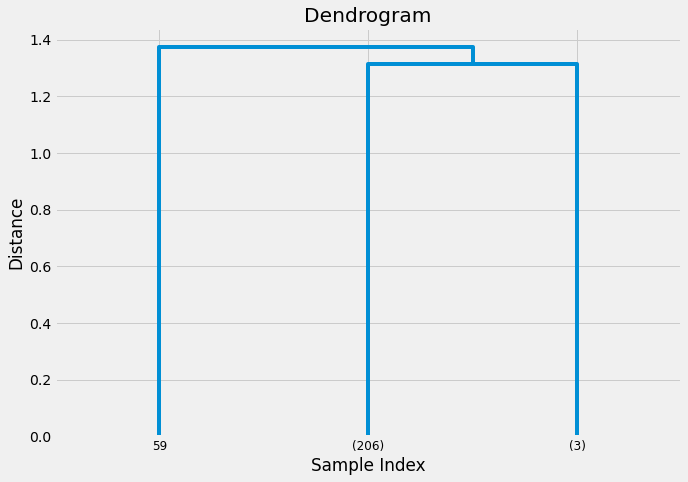

In [64]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
plt.ylabel('Distance')
plt.xlabel('Sample Index')
dend = shc.dendrogram(shc.linkage(X_Normalized, 'single'), p = 3, truncate_mode = 'lastp')

In [65]:
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'single')

y_hc = pd.DataFrame(hc.fit_predict(X_Normalized) + 1, columns = ['Class'])
accuracy = round((np.mean(y_hc==y))*100)
print('Accuracy: {}'.format(accuracy))

Accuracy: Class    33.0
dtype: float64


The above misclassification error makes sense becasue we have close to all of our samples inside of one cluster. Therefore it is intuitive that one third of those points inside of that cluster would be correctly identified, while the other two thirds would not.

The dendrogram is another way of seeing a distribution in the data. Another view of the distribution is plotted below.

C:\Users\Jonathan Sands\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


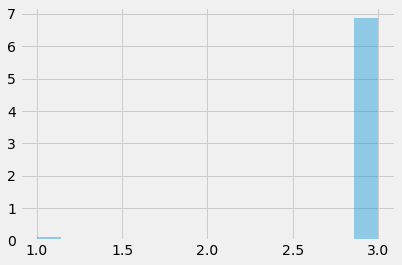

In [66]:
sns.distplot(y_hc)

### Apply complete linkage and report
### 1. The dendrogram
### 2. The class distribution at level of the dendrogram where there are only three clusters.

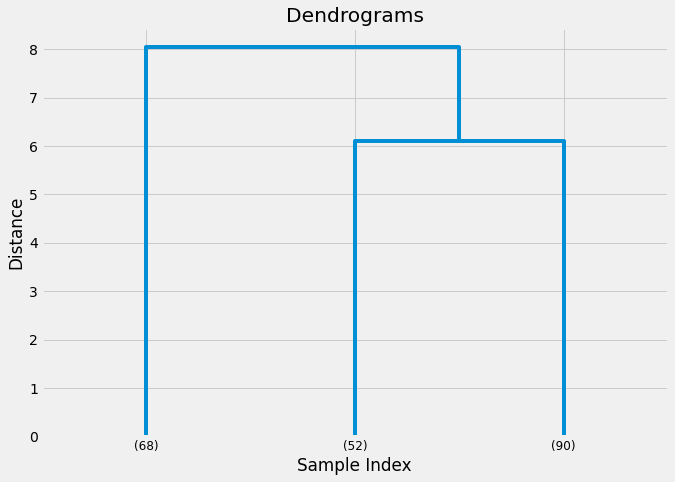

In [67]:
hc = AgglomerativeClustering(n_clusters = 3, linkage = 'complete').fit(X_Normalized)


plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
plt.ylabel('Distance')
plt.xlabel('Sample Index')
dend = shc.dendrogram(shc.linkage(X_Normalized, 'complete'), p = 3, truncate_mode = 'lastp')

The complete linkage shows a much better distribution across the classes.

In [68]:
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'complete')

y_hc = pd.DataFrame(hc.fit_predict(X_Normalized) + 1, columns = ['Class'])
accuracy = round((np.mean(y_hc==y))*100)
print('Accuracy: {}'.format(accuracy))

Accuracy: Class    41.0
dtype: float64


### Hierarchical clustering summary
While there is a small difference, I believe that Hierarchical clustering does a better job of identifying the class labels versus just KMeans. While KMeans achieved a distribution that represents our class label distribution better than Hierarchical Clustering did, it has a higher misclassification error among our data set. Because accurate classification is what we are looking for, I believe Hierarchical will be able to achieve this higher level of accurate clustering.


### Create an executive summary.

In this problem, we are seeking a strategy to be able to accuratly identify wheat species (kama, Rosa, and Canadian) based on select features of their kernels (area, perimeter, compactness, length of kernel, width of kernel, asymmetry coefficient, length of kernel groove). To do this, we used a clustering algorithm known as KMeans. KMeans approaches the problem by visualizing the n features on an n dimmensional plot, assigning a user specified amount of randomly placed centroids, and assigning the points on the plot to a cluster centered around their closest centroid. It then readjusts the centeroid based on the mean distance between all points within the centroid and reassesses which points should belong to that cluster. We continue this centroid adjustment and point assessment until we achieve convergence. 

For this example specifically, we can assume that 3 clusters is the ideal number, but to confirm this, we tested for 1-9 clusters. After viewing the accuracy, class label distribution, and inertia of each cluster count, we can confirm that 3 clusters proved to be the most accurate among the KMeans methods we tested. We confirmed this with the elbow test which finds the optimal point of decrease in inertia.

Continuing on, we decided to test a Hierarchical clustering as well. Visualizing hierarchical clustering is similar to decision trees, but in reverse order. If we have n samples, we start with n clusters, where each cluster contains exactly one sample. Moving on we begin to group samples together based on their distance. The Agglomerative clustering algorithm we used here can be viewed in detail here (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). It follows the general structure of a typical hierarchical clustering algorithm, using the distance matrix as a guideline to finding the closest clusters, and culminates in the end with one single cluster that contains all samples. 

To implement this and discover it's effectiveness, we visualized it with a dendrogram, which is a decision tree like structure used to visualize the clustering. We used the truncate attribute to stop it when we had 3 clusters. Using single linkage, our information was rather useless but using complete linkage allows us to achieve a more evenly labeled class distribution.

Between the two methods tested, KMeans and Hierarchical, Hierarchical had better results as far as accuracy but KMeans provided a more evenly representative class label assignment distribution.

## KFold Splits

### Use 10-fold cross validation and at least five different configurations to produce a decision tree classifier. Report the results obtained for the different configurations and chose one as being the best among the configurations you tried. Explain your answer.

In [89]:
kf = KFold(n_splits = 10)

In [90]:
#Implementing KFold over a decision tree
minSplit = [2, 4, 6, 8, 10]
minLeaf = [2, 4, 6, 8, 10]

for i in range(len(minSplit)):
    
    for j in range(len(minLeaf)):
    
        clf = tree.DecisionTreeClassifier(criterion = "gini", min_samples_split = minSplit[i], min_samples_leaf = minLeaf[j], min_impurity_decrease = .001, random_state = 0)
    
        clf = clf.fit(X_train, y_train)
    

    
        scores = cross_val_score(clf, X, y, cv = kf)

        #Finding the R Score 
    
        print('\n\n\n\nWith the minimum number of samples required to split of: {}'.format(minSplit[i]))
    
        print('\nWith a minimum number of samples required to create a leaf of: {}'.format(minLeaf[j]))
    
        print('\nOur cross validation score is: {}'.format(np.mean(scores)))
    
        print('\nThe total nodes for the tree are {}'.format(clf.tree_.node_count))






With the minimum number of samples required to split of: 2

With a minimum number of samples required to create a leaf of: 2

Our cross validation score is: 0.8380952380952381

The total nodes for the tree are 21




With the minimum number of samples required to split of: 2

With a minimum number of samples required to create a leaf of: 4

Our cross validation score is: 0.8857142857142858

The total nodes for the tree are 17




With the minimum number of samples required to split of: 2

With a minimum number of samples required to create a leaf of: 6

Our cross validation score is: 0.8857142857142856

The total nodes for the tree are 13




With the minimum number of samples required to split of: 2

With a minimum number of samples required to create a leaf of: 8

Our cross validation score is: 0.8761904761904761

The total nodes for the tree are 13




With the minimum number of samples required to split of: 2

With a minimum number of samples required to create a leaf of: 10

O

For this instance, I am going to select the option where our min sample split is 10 and our min sample leaf is 2. Here we get a cross validation score of 0.9095238095238095 using the scikit learn function cross_val_score which takes our KFold cross validation indices and returns the cross validation score for each index set in the for of an entry in an array.
It was then my job to take the average of all these entries and set that as our cross validation score. Intuitively, I selected the highest cross validation score. While there were several other scores that were close to the cv score we selected, I chose the one with the most total nodes so we would have the chance to prune without losing too much information.

### For the best tree configuration, report the misclassification matrix and interpret it. In your opinion, is accuracy a good way to interpret the performance of the model? If not, suggest other measures.

In [91]:
#Create the decision tree of our desired settings
train, test = train_test_split(data, random_state = 0)

X_Train = train.iloc[:,:-1]
y_Train = train.iloc[:,-1]

X_Test = test.iloc[:,:-1]
y_Test = test.iloc[:,-1]

clf = tree.DecisionTreeClassifier(criterion = "gini", min_samples_split = 10, min_samples_leaf = 2, min_impurity_decrease = .001, random_state = 0)
    
clf = clf.fit(X_Train, y_Train)
    
prediction = clf.predict(X_Test)

In [94]:
#R Score and misclassification error
print('\nThe R squared score is :  {}'.format(clf.score(X_Test, y_Test)))

print('\nOur error for this classifier was {}%'.format(mean_squared_log_error(y_Test, prediction)*100))



The R squared score is :  0.9245283018867925

Our error for this classifier was 2.4334149728730825%


In [93]:
#Construct Confusion Matrix
confusion_matrix(y_Test, prediction)

array([[15,  0,  2],
       [ 2, 19,  0],
       [ 0,  0, 15]], dtype=int64)

To me, accuracy proved to be a solid measure of the classifier's performance. We got an R score (mean accuracy on the test data) of over .9245 which is very good, this shows that our classifier performs on the test data. Our classifier only misclassified 4 points. 

### What are the most important three attributes for classifying the wheat data?

In [95]:
importance = clf.feature_importances_
print('\n')
for i,v in enumerate(importance):
    print(data.columns[i] + ', Score: %.5f' % (v))



Area, Score: 0.38871
Perimeter, Score: 0.00000
Compactness, Score: 0.00000
Length of Kernel, Score: 0.00000
Width of Kernel, Score: 0.00000
Asymmetry Coefficient, Score: 0.04036
Length of Kernel Groove, Score: 0.57093


The three most important features in the data are the length of the Kernel Groove, the area, and the asymmetry coefficient.

### Create a graph that will allow you to visualize the data in the 3-dimensional space of the most important attributes. Interpret the graph.

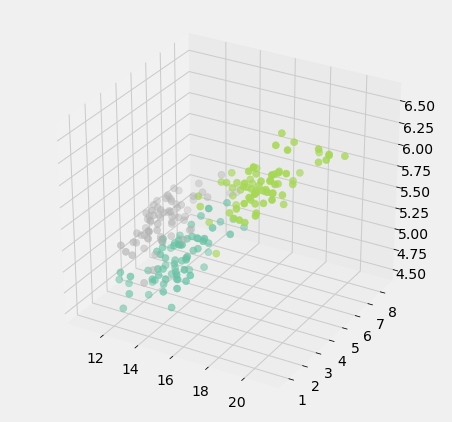

In [96]:

plt.figure('K-Means', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(data.iloc[:,0],data.iloc[:,5],data.iloc[:,6], c = data.iloc[:,-1], cmap='Set2', s=50)

Above is a 3D representation of the data, it is pretty easy to identify three clusters, each of which represents one of our 3 class labels.

### Are there any other techniques that can help identify variables for data visualization? Explain your answer and include any analysis you will perform to answer this question.

For the first problem, in my approach to doing hierarchical clustering I thought of using PCA. I knew if I set a PCA feature count to 3 that I could visualize the variables and after using seaborn's pairplot function, that shows relation between different features, it's easy to see that a lot of the features are correlated. Check the diagram below: 

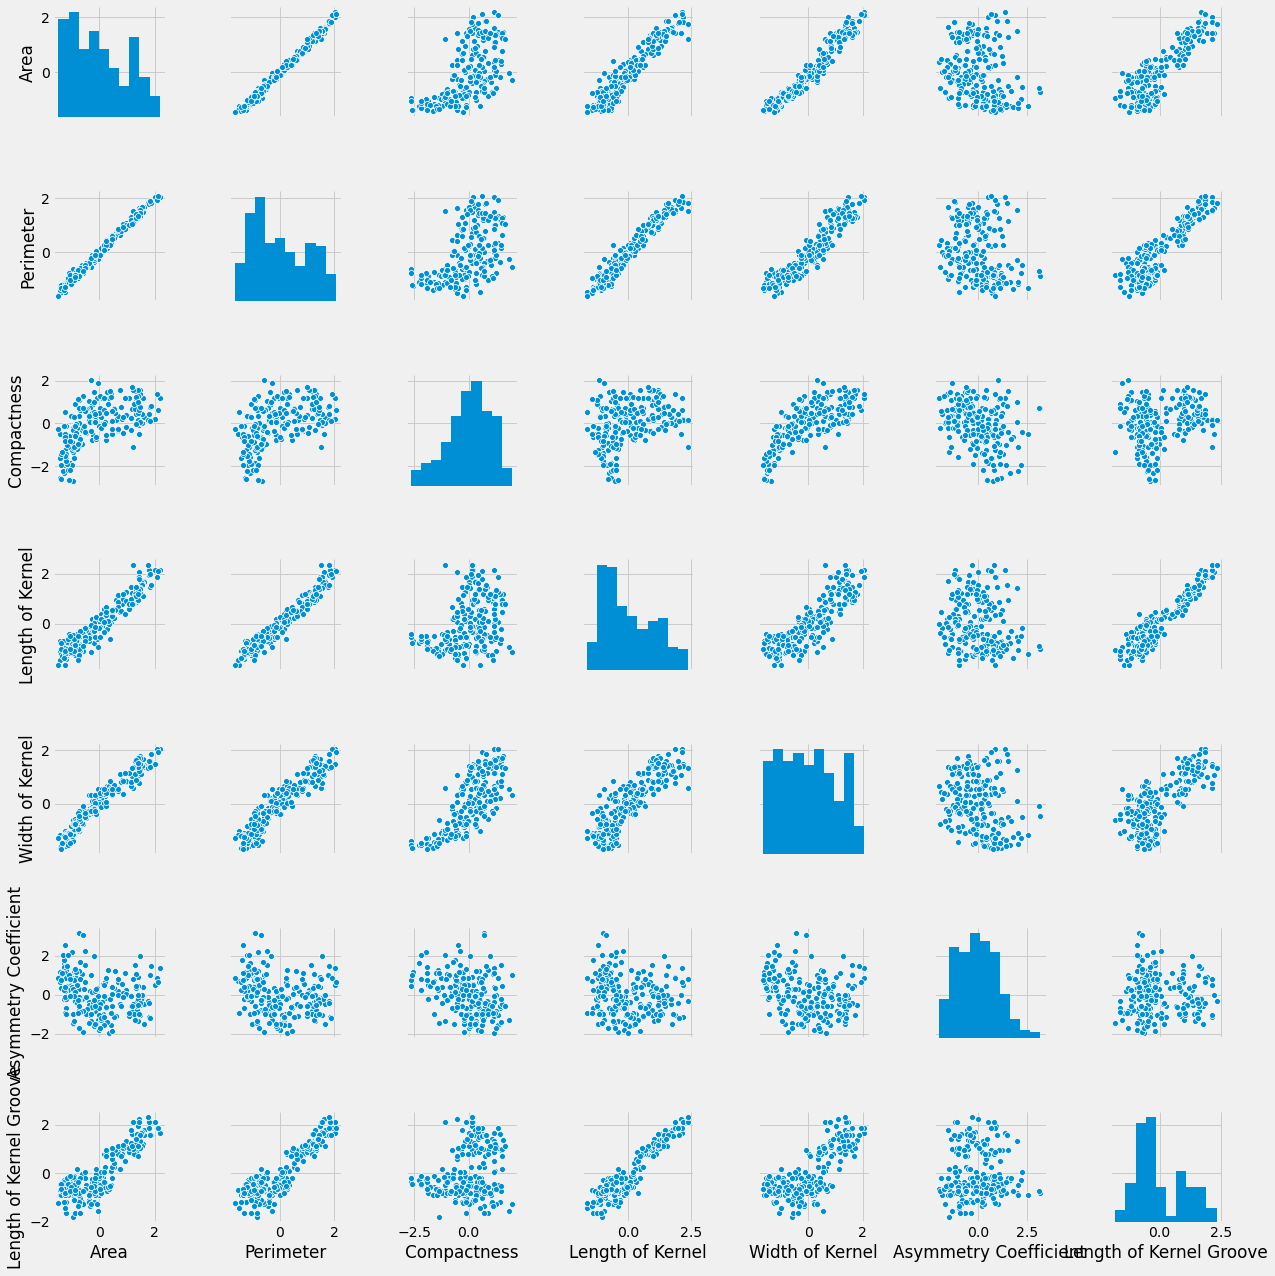

In [97]:
#Normalize the features
X_Normalized = pd.DataFrame(stats.zscore(X), columns = ['Area', 'Perimeter', 'Compactness','Length of Kernel', 'Width of Kernel', 'Asymmetry Coefficient', 'Length of Kernel Groove'])
X_Normalized

#Show pairplot of feature relations
sns.pairplot(X_Normalized)

It's clear that area is correlated with length of kernel, width of kernel, and length of groove. My thought was to normalize these features first with z-score normalization and then apply PCA to reduce the dimensionality to 3 in order to plot. Below is my methodology for obtaining the 3D matrix (it's actually 4D because I have a 'Class' column but this is easy to work around).

In [96]:
#Apply PCA
pca = PCA(n_components = 3)
princ_components = pca.fit_transform(X)
princDF = pd.DataFrame(data = princ_components, columns = ['comp 1', 'comp 2', 'comp 3'])

#Create 3D matrix and display
ThreeD = pd.concat([princDF, y], axis = 1)
ThreeD

,comp 1,comp 2,comp 3,Class
0,-0.254271,-1.239042,0.029219,1
1,-0.719384,-2.475772,0.198884,1
2,-1.544840,-0.839081,0.515727,1
3,-1.983767,-1.288245,0.417918,1
4,0.627280,-2.096377,0.304547,1
...,...,...,...,...
166,-3.451480,1.383103,-0.150166,3
167,-3.705069,0.103579,-0.401962,3
168,-4.651396,0.760923,-0.265439,3
169,-4.780541,-0.062697,-0.245061,3


While I used this is the first question to try and better visualize the clusters as well as misclassified points, it could easily be applied to this problem as well. However, something to consider is that determining feature importance after applying this method would be rather pointless. Because PCA is a reduction tool, it will help provide the same model results but may make the interpretation of how the model ran less clear because we no longer have our attributes from the original data set, but instead attributes that the PCA algorithm created.

Doing PCA and normalization to the first problem increased accuracy by more than 10% in some cases. Just goes to show that preprocessing, cleaning, reduction, etc are just as if not more important than implementing actual algorithms.